# Anchored CorEx: Topic Modeling with Minimal Domain Knowledge

**Author:** [Ryan J. Gallagher](http://ryanjgallagher.github.io/)  

**Last updated:** 07/21/2018

This notebook walks through how to use the CorEx topic model code. This includes fitting CorEx to your data, examining the topic model output, outputting results, building a hierarchical topic model, and anchoring words to topics.

Details of the CorEx topic model and evaluations against unsupervised and semi-supervised variants of LDA can be found in our TACL paper:

Gallagher, Ryan J., Kyle Reing, David Kale, and Greg Ver Steeg. "[Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244)." *Transactions of the Association for Computational Linguistics (TACL)*, 2017.

In [1]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

from corextopic import corextopic as ct
from corextopic import vis_topic# jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

import pandas as pd
from sklearn.feature_extraction import text


## Loading the 20 Newsgroups Dataset

We need to first load data to run the CorEx topic model. We'll use the 20 Newsgroups dataset, which scikit-learn provides functionality to access.

In [2]:
data = pd.read_csv('../Data/RYANDATA_filt.csv')
data.columns = ['V0', 'topic', 'authors','title','journal','year','vol_issue','doi','abstract']
print(data.groupby('topic')['title'].nunique())

topic
BONE                              1957
CARDIOVASCULAR/CARDIOPULMONARY    1164
CELLULAR/SUBCELLULAR              1217
COMPARATIVE                       1602
DENTAL/ORAL/FACIAL                1346
ERGONOMICS                         502
EVOLUTION/ANTHROPOLOGY             998
GAIT/LOCOMOTION                   3184
JOINT/CARTILAGE                   1429
METHODS                           1440
MODELING                          1240
MUSCLE                             705
NEURAL                            1705
ORTHOPAEDICS/SPINE                2286
ORTHOPAEDICS/SURGERY              3056
PROSTHETICS/ORTHOTICS              554
REHABILITATION                    1176
ROBOTICS                          1059
SPORT/EXERCISE                    2810
TENDON/LIGAMENT                   1551
TISSUE/BIOMATERIAL                2117
TRAUMA/IMPACTTESTING               690
VETERINARY/AGRICULTURAL            702
VISUAL/VESTIBULAR/EYE              777
Name: title, dtype: int64


In [3]:
#split data keeping distribution
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits= 1, 
                             test_size = 0.2, 
                             random_state = 0)

for train_idx, test_idx in sss.split(data['title'],data['topic']):
    X_train, X_test = data['title'][train_idx], data['title'][test_idx]
    y_train, y_test = data['topic'][train_idx], data['topic'][test_idx]


y_train.value_counts() #same distribution as original data

GAIT/LOCOMOTION                   2547
ORTHOPAEDICS/SURGERY              2445
SPORT/EXERCISE                    2248
ORTHOPAEDICS/SPINE                1829
TISSUE/BIOMATERIAL                1693
BONE                              1565
NEURAL                            1364
COMPARATIVE                       1281
TENDON/LIGAMENT                   1241
METHODS                           1152
JOINT/CARTILAGE                   1143
DENTAL/ORAL/FACIAL                1077
MODELING                           992
CELLULAR/SUBCELLULAR               974
REHABILITATION                     941
CARDIOVASCULAR/CARDIOPULMONARY     931
ROBOTICS                           847
EVOLUTION/ANTHROPOLOGY             798
VISUAL/VESTIBULAR/EYE              622
MUSCLE                             564
VETERINARY/AGRICULTURAL            562
TRAUMA/IMPACTTESTING               552
PROSTHETICS/ORTHOTICS              443
ERGONOMICS                         402
Name: topic, dtype: int64

In [4]:
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
import numpy as np
np.random.seed(0)

# import nltk
# nltk.download('wordnet')

#tokenize, lemmatized, stemmed
stemmer = SnowballStemmer(language='english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(lemmatize_stemming(token))
            result.append(token)
    result = ' '.join(result)        
    return result

doc_sample = X_train[0]
print('Original document: ')
words = []
for doc in [doc_sample]:
    print(doc)
print('\nTokenized and lemmatized document: ')
print(preprocess(doc_sample),'\n')

X_train_proc = X_train.map(preprocess)

train_data = pd.DataFrame({'title':X_train_proc, 'topic':y_train})
train_data
                      
          
         

Original document: 
Proximal radius fracture morphology following axial force impact: a biomechanical evaluation of fracture patterns

Tokenized and lemmatized document: 
proximal radius fracture morphology following axial force impact biomechanical evaluation fracture patterns 



,title,topic
8793,overcoming limitations harmonic ratio reliable...,GAIT/LOCOMOTION
6411,influence different abutment designs biomechan...,DENTAL/ORAL/FACIAL
24002,content validation clinical assessment instrum...,REHABILITATION
35014,neural control adaptive neural forward models ...,ROBOTICS
16312,dual developmental origin spinal cerebrospinal...,NEURAL
21506,remplissage versus latarjet engaging hill sach...,ORTHOPAEDICS/SURGERY
3450,aquantitative image analysis cellular cytoskel...,CELLULAR/SUBCELLULAR
34341,gait trajectory rolling planning control hexap...,ROBOTICS
11238,functional properties chondrocytes articular c...,JOINT/CARTILAGE
4816,effect foot posture capacity apply free moment...,COMPARATIVE


The topic model assumes input is in the form of a doc-word matrix, where rows are documents and columns are binary counts. We'll vectorize the newsgroups data, take the top 20,000 words, and convert it to a sparse matrix to save on memory usage. Note, we use binary count vectors as input to the CorEx topic model.

In [5]:
#transform title data into sparse matrix
#additional stop words
stop_words = text.ENGLISH_STOP_WORDS.union(['biomechanics','biomechanical','locomotor','locomotion','study'])
#CountVectorizer
vectorizer = CountVectorizer(min_df=3,
                            max_df=0.5,
                            max_features= 20000,
                            ngram_range=(1,3),
                            strip_accents='unicode',
                            lowercase=True,
                            analyzer='word',
                            stop_words=stop_words,
                            token_pattern= '[a-zA-Z-0-9]{3,}' #TRY BINARY = TRUE
                           )
doc_word = vectorizer.fit_transform(train_data['title'])
doc_word = ss.csr_matrix(doc_word)
doc_word.shape # n_docs x m_words


(28213, 20000)

In [135]:
#get common words for each topic
n_top_topics = 3
title_subset = []
top_words = []
freq_list = []
words_freq = []
for i in train_data.groupby('topic'):
    title_subset.append(i)
for a in title_subset:  
    a # all titles in a given topic
    bag_of_words = vectorizer.transform(a[1]['title'])
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    words_freq = words_freq[:n_top_topics]
    for item in list(zip(*words_freq))[0]:
        freq_list.append(item)

freq_list = [freq_list[i:i + n_top_topics] for i in range(0, len(freq_list), n_top_topics)]

In [148]:
anchor_list = pd.DataFrame({'top_words':freq_list})
anchor_list.iloc[0]['top_words'] #will use this to anchor model later. 


['bone', 'fracture', 'model']

Our doc-word matrix is 11,314 documents by 20,000 words. Let's get the words that label the columns. We'll need these for outputting readable topics and later for anchoring.

In [149]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))
len(words)

20000

## CorEx Topic Model

The main parameters of the CorEx topic model are:
+ **`n_hidden`**: number of topics ("hidden" as in "hidden latent topics")
+ **`words`**: words that label the columns of the doc-word matrix (optional)
+ **`docs`**: document labels that label the rows of the doc-word matrix (optional)
+ **`max_iter`**: number of iterations to run through the update equations (optional, defaults to 200)
+ **`verbose`**:  if `verbose=1`, then CorEx will print the topic TCs with each iteration
+ **`seed`**:     random number seed to use for model initialization (optional)

We'll train a topic model with 50 topics. (This will take a few minutes.)

In [ ]:
# Train the CorEx topic model with 50 topics
n_topics = 27
topic_model = ct.Corex(n_hidden=n_topics, 
                       words=words, 
                       max_iter=200, 
                       verbose=False, 
                       seed=1, 
                       docs = train_data['title'])
topic_model.fit(doc_word, words=words,);
print('model fit with',n_topics,'topics')

## CorEx Output

### Topics

The CorEx topic model provides functionality for easily accessing the topics. Let's take a look one of the topics.

In [59]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=0, n_words=10)

[('ligament', 0.12565747836980273),
 ('cruciate', 0.09301666969080115),
 ('cruciate ligament', 0.0909861274986143),
 ('anterior cruciate', 0.07989143170087362),
 ('anterior cruciate ligament', 0.07959001712899003),
 ('anterior', 0.062028957848339686),
 ('ligament reconstruction', 0.05385770791021663),
 ('reconstruction', 0.049339688676797264),
 ('cruciate ligament reconstruction', 0.04290597857508636),
 ('bundle', 0.012307634420431373)]

The topic words are those with the highest *mutual information* with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. Theoretically, mutual information is always positive. If the CorEx output returns a negative mutual information from **`get_topics()`**, then the absolute value of that quantity is the mutual information between the topic and the *absence* of that word.

If the column labels have not been specified through **`words`**, then the code will return the column indices for the top words in each topic.

We can also retrieve all of the topics at once if we would like.

In [60]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: ligament,cruciate,cruciate ligament,anterior cruciate,anterior cruciate ligament,anterior,ligament reconstruction,reconstruction,cruciate ligament reconstruction,bundle
1: fixation,fractures,screw,plate,pedicle,locking,suture,screws,screw fixation,distal
2: cord,spinal cord,spinal,cord injury,spinal cord injury,injury,stem,stem cells,cells,articular cartilage
3: finite,element,finite element,element analysis,finite element analysis,lumbar,spine,total,arthroplasty,cervical
4: gait,walking,lower,limb,running,kinematics,lower limb,knee,foot,ankle
5: implant,implants,dental,stress,stress distribution,defect,titanium,distribution,dental implants,porous
6: rotator,cuff,rotator cuff,parkinson,parkinson disease,reaction,ground,palsy,cerebral palsy,ground reaction
7: specific,aortic,abdominal,patient specific,patient,wall,cancer,abdominal aortic,aneurysm,subject
8: bone,cortical bone,marrow,femoral,bone marrow,cortical,density,tendon bone,mineral,femoral neck
9: evolution,morphology,implicat

The first topic for the newsgroup data tends to be less coherent than expected because of encodings and other oddities in the newsgroups data.  

We can also get the column indices instead of the column labels if necessary.

In [61]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(8978, 0.05328271639472043),
 (9013, 0.027634555214009572),
 (4509, 0.019933710042152365),
 (16900, 0.019347739250012),
 (16904, 0.014464403463662854),
 (4381, 0.011488413745435036),
 (18144, 0.011181573806631597),
 (5178, 0.010635286835666334),
 (4513, 0.009754625693297927),
 (13193, 0.008446275292428968)]

If we need to directly access the topic assignments for each word, they can be accessed through **`cluster`**.

In [62]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[7 7 7 ... 1 5 5]
(20000,)


### Document Labels

As with the topic words, the most probable documents per topic can also be easily accessed. Documents are sorted according to log probabilities which is why the highest probability documents have a score of 0 ($e^0 = 1$) and other documents have negative scores (for example, $e^{-0.5} \approx 0.6$).

In [69]:
# Print a single topic from CorEx topic model
topic_n = 0
indx = topic_model.get_top_docs(topic=topic_n, n_docs=10, sort_by='log_prob')
print("\nPapers for topic",topic_n)
for i in indx:
    print(i[0],train_data['title'].iloc[i[0]],'\n')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices

Papers for topic 0
20496 anterolateral ligament reconstruction required reconstructed knees associated injury anterolateral structures robotic analysis rotational knee stability 

18980 wrist finger flexor muscles olive baboons papio anubis 

1506 strategy enhance artificial ligament graft bone tunnel 

906 differences incidence anterior cruciate ligament medial collateral ligament meniscal injuries collegiate high school sports 

24796 gait strategy patients ehlers danlos syndrome hypermobility type syndrome 

26284 comparison graft length changes knee motion different anatomic single bundle anterior cruciate ligament reconstruction approaches biomechanical study 

20130 prevention anterior cruciate ligament injuries sports systematic review risk factors male athletes 

7552 vivo length patterns medial collateral ligament stance phase gait 

27404 vitro comparison cortical cortico cancellous femoral suspen

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [70]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(28213, 27)


We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through **`labels`**.

In [71]:
print(topic_model.labels.shape) # n_docs x k_topics

(28213, 27)


In [72]:
corex_pred_data = pd.DataFrame(topic_model.p_y_given_x)
corex_pred_data #title rows, column topic numbers

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.000061,0.000191,0.000098,0.000176,0.999999,0.002217,0.001612,0.000969,0.000491,0.001293,...,0.002953,0.006247,0.000943,0.005894,0.273797,0.004897,0.001529,0.005258,0.005929,0.052003
1,0.000061,0.000191,0.000098,0.999999,0.003139,0.999999,0.001612,0.000969,0.000491,0.004326,...,0.002953,0.006248,0.000944,0.059198,0.007335,0.004896,0.001529,0.005369,0.006436,0.999999
2,0.000061,0.000191,0.000098,0.000176,0.998752,0.000427,0.044767,0.000969,0.000491,0.001294,...,0.002953,0.006247,0.000944,0.005917,0.065485,0.004896,0.012090,0.999999,0.006423,0.011509
3,0.000061,0.000191,0.000098,0.000176,0.060692,0.000427,0.001612,0.000969,0.000491,0.001294,...,0.002953,0.033220,0.006647,0.005918,0.024435,0.035609,0.001529,0.005363,0.006405,0.011538
4,0.000061,0.000191,0.003638,0.000176,0.012982,0.000427,0.001612,0.000969,0.000491,0.999999,...,0.002953,0.821368,0.000944,0.005916,0.007335,0.015760,0.001529,0.005369,0.006436,0.011462
5,0.000061,0.999999,0.000098,0.000176,0.003139,0.011356,0.999999,0.000969,0.999999,0.001294,...,0.002953,0.006248,0.000944,0.005916,0.007335,0.004896,0.001529,0.005369,0.074238,0.011396
6,0.000061,0.000191,0.000098,0.001049,0.000365,0.000427,0.001612,0.000969,0.000491,0.001294,...,0.002953,0.006248,0.999999,0.005916,0.007335,0.004896,0.001529,0.005369,0.006439,0.011461
7,0.000061,0.000191,0.000098,0.000176,0.096989,0.000427,0.001612,0.000969,0.000491,0.001294,...,0.002953,0.006248,0.000944,0.005916,0.057811,0.004895,0.001529,0.005369,0.006427,0.011354
8,0.000061,0.000191,0.994823,0.000176,0.003139,0.000427,0.001612,0.059000,0.000491,0.005063,...,0.002953,0.006248,0.422736,0.999999,0.007335,0.004896,0.001529,0.005369,0.006435,0.011417
9,0.000163,0.000191,0.000098,0.000176,0.999999,0.000427,0.851093,0.000969,0.000491,0.999999,...,0.002953,0.006248,0.017903,0.005913,0.007332,0.195478,0.001529,0.005364,0.006376,0.011608


Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

## Total Correlation and Model Selection

### Overall TC

Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through **`tc`** and is reported in nats.

In [73]:
topic_model.tc

10.734384738435843

**Model selection:** CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

### Topic TC

The overall total correlation is the sum of the total correlation per each topic. These can be accessed through **`tcs`**. For an unsupervised CorEx topic model, the topics are always sorted from high to low according to their TC. For an anchored CorEx topic model, the topics are not sorted, and are outputted such that the anchored topics come first.

In [74]:
topic_model.tcs.shape # k_topics

(27,)

In [75]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

10.734384738435843
10.734384738435843


**Selecting number of topics:** one way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

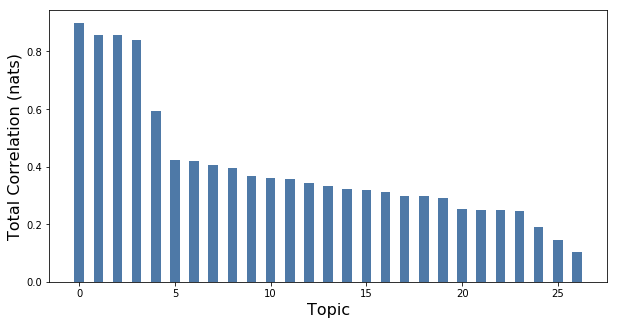

In [76]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

We see the first topic is much more informative than the other topics. Given that we suspect that this topic is picking up on image encodings (as given by "dsl" and "n3jxp" in the topic) and other boilerplate text (as given by the high TC and lack of coherence of the rest of the topic), we could consider doing additional investigation and preprocessing to help ensure that the CorEx topic model does not pick up on these patterns which are not insightful.

### Pointwise Document TC

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through **`log_z`**.

In [78]:
topic_model.log_z.shape # n_docs x k_topics

(28213, 27)

In [79]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

[0.89898803 0.85852308 0.85643471 0.84136796 0.59416987 0.42346793
 0.4200857  0.40726644 0.39585665 0.36759709 0.35938127 0.35783007
 0.34417091 0.33393502 0.32090076 0.32050596 0.31306224 0.2979806
 0.29788815 0.29276047 0.25131951 0.24903485 0.24767016 0.24749841
 0.18888326 0.14522183 0.1025838 ]
[0.89898803 0.85852308 0.85643471 0.84136796 0.59416987 0.42346793
 0.4200857  0.40726644 0.39585665 0.36759709 0.35938127 0.35783007
 0.34417091 0.33393502 0.32090076 0.32050596 0.31306224 0.2979806
 0.29788815 0.29276047 0.25131951 0.24903485 0.24767016 0.24749841
 0.18888326 0.14522183 0.1025838 ]


The pointwise total correlations in **`log_z`** represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics (see references below).

## Hierarchical Topic Models

The **`labels`** attribute gives the binary topic expressions for each document and each topic. We can use this output as input to another CorEx topic model to get latent representations of the topics themselves. This yields a hierarchical CorEx topic model. Like the first layer of the topic model, one can determine the number of latent variables to add in higher layers through examination of the topic TCs.

In [80]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

If you have `graphviz` installed, then you can output visualizations of the hierarchial topic model to your current working directory. One can also create custom visualizations of the hierarchy by properly making use of the **`labels`** attribute of each layer.

In [81]:
""" This module implements some visualizations based on CorEx representations.
"""

import os
from shutil import copyfile
import codecs
import numpy as np
import matplotlib
matplotlib.use('Agg') # to create visualizations on a display-less server
import pylab
import networkx as nx
import textwrap
import scipy.sparse as ss
import sklearn.feature_extraction.text as skt
#import cPickle, pickle # neither module is used, and cPickle is not part of Anaconda build, so commented for LF run
import corextopic as ct
import sys, traceback
from time import time
import re
import sklearn.feature_extraction.text as skt
from nltk.stem.snowball import *
pattern = '\\b[A-Za-z]+\\b'
np.seterr(all='ignore')

class Corex(object):
    def vis_rep(corex, data=None, row_label=None, column_label=None, prefix='topics'):
        """Various visualizations and summary statistics for a one layer representation"""
        if column_label is None:
            column_label = list(map(str, range(data.shape[1])))
        if row_label is None:
            row_label = list(map(str, range(corex.n_samples)))

        alpha = corex.alpha

        print('Print topics in text file')
        output_groups(corex.tcs, alpha, corex.mis, column_label, corex.sign, prefix=prefix)
        output_labels(corex.labels, row_label, prefix=prefix)
        output_cont_labels(corex.p_y_given_x, row_label, prefix=prefix)
        output_strong(corex.tcs, alpha, corex.mis, corex.labels, prefix=prefix)
        anomalies(corex.log_z, row_label=row_label, prefix=prefix)
        plot_convergence(corex.tc_history, prefix=prefix)
        if data is not None:
            plot_heatmaps(data, alpha, corex.mis, column_label, corex.p_y_given_x, prefix=prefix)


    def vis_hierarchy(corexes, column_label=None, max_edges=100, prefix='topics', n_anchors=0):
        """Visualize a hierarchy of representations."""
        if column_label is None:
            column_label = list(map(str, range(corexes[0].alpha.shape[1])))

        # make l1 label
        alpha = corexes[0].alpha
        mis = corexes[0].mis
        l1_labels = []
        annotate = lambda q, s: q if s > 0 else '~' + q
        for j in range(corexes[0].n_hidden):
            # inds = np.where(alpha[j] * mis[j] > 0)[0]
            inds = np.where(alpha[j] >= 1.)[0]
            inds = inds[np.argsort(-alpha[j, inds] * mis[j, inds])]
            group_number = str('red_') + str(j) if j < n_anchors else str(j)
            label = group_number + ':' + ' '.join([annotate(column_label[ind], corexes[0].sign[j,ind]) for ind in inds[:6]])
            label = textwrap.fill(label, width=25)
            l1_labels.append(label)

        # Construct non-tree graph
        weights = [corex.alpha.clip(0, 1) * corex.mis for corex in corexes[1:]]
        node_weights = [corex.tcs for corex in corexes[1:]]
        g = make_graph(weights, node_weights, l1_labels, max_edges=max_edges)

        # Display pruned version
        h = g.copy()  # trim(g.copy(), max_parents=max_parents, max_children=max_children)
        edge2pdf(h, prefix + '/graphs/graph_prune_' + str(max_edges), labels='label', directed=True, makepdf=True)

        # Display tree version
        tree = g.copy()
        tree = trim(tree, max_parents=1, max_children=False)
        edge2pdf(tree, prefix + '/graphs/tree', labels='label', directed=True, makepdf=True)

        # Output JSON files
        try:
            import os
            #copyfile(os.path.dirname(os.path.realpath(__file__)) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
            print(os.path.dirname(os.path.realpath('tests')) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
            copyfile(os.path.dirname(os.path.realpath('tests')) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
        except:
            print("Couldn't find 'force.html' file for visualizing d3 output")
        import json
        from networkx.readwrite import json_graph

        mapping = dict([(n, tree.node[n].get('label', str(n))) for n in tree.nodes()])
        tree = nx.relabel_nodes(tree, mapping)
        json.dump(json_graph.node_link_data(tree), safe_open(prefix + '/graphs/force.json', 'w+'))
        json.dump(json_graph.node_link_data(h), safe_open(prefix + '/graphs/force_nontree.json', 'w+'))

        return g


    def plot_heatmaps(data, alpha, mis, column_label, cont, topk=40, athresh=0.2, prefix=''):
        import seaborn as sns
        cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
        import matplotlib.pyplot as plt
        m, nv = mis.shape
        for j in range(m):
            inds = np.where(np.logical_and(alpha[j] > athresh, mis[j] > 0.))[0]
            inds = inds[np.argsort(- alpha[j, inds] * mis[j, inds])][:topk]
            if len(inds) >= 2:
                plt.clf()
                order = np.argsort(cont[:,j])
                if type(data) == np.ndarray:
                    subdata = data[:, inds][order].T
                else:
                    # assume sparse
                    subdata = data[:, inds].toarray()
                    subdata = subdata[order].T
                columns = [column_label[i] for i in inds]
                fig, ax = plt.subplots(figsize=(20, 10))
                sns.heatmap(subdata, vmin=0, vmax=1, cmap=cmap, yticklabels=columns, xticklabels=False, ax=ax, cbar_kws={"ticks": [0, 0.5, 1]})
                plt.yticks(rotation=0)
                filename = '{}/heatmaps/group_num={}.png'.format(prefix, j)
                if not os.path.exists(os.path.dirname(filename)):
                    os.makedirs(os.path.dirname(filename))
                plt.title("Latent factor {}".format(j))
                plt.savefig(filename, bbox_inches='tight')
                plt.close('all')
                #plot_rels(data[:, inds], map(lambda q: column_label[q], inds), colors=cont[:, j],
                #          outfile=prefix + '/relationships/group_num=' + str(j), latent=labels[:, j], alpha=0.1)


    def make_graph(weights, node_weights, column_label, max_edges=100):
        all_edges = np.hstack(list(map(np.ravel, weights)))
        max_edges = min(max_edges, len(all_edges))
        w_thresh = np.sort(all_edges)[-max_edges]
        print('weight threshold is %f for graph with max of %f edges ' % (w_thresh, max_edges))
        g = nx.DiGraph()
        max_node_weight = max([max(w) for w in node_weights])
        for layer, weight in enumerate(weights):
            m, n = weight.shape
            for j in range(m):
                g.add_node((layer + 1, j))
                g.node[(layer + 1, j)]['weight'] = 0.3 * node_weights[layer][j] / max_node_weight
                for i in range(n):
                    if weight[j, i] > w_thresh:
                        if weight[j, i] > w_thresh / 2:
                            g.add_weighted_edges_from([( (layer, i), (layer + 1, j), 10 * weight[j, i])])
                        else:
                            g.add_weighted_edges_from([( (layer, i), (layer + 1, j), 0)])

        # Label layer 0
        for i, lab in enumerate(column_label):
            g.add_node((0, i))
            g.node[(0, i)]['label'] = lab
            g.node[(0, i)]['name'] = lab  # JSON uses this field
            g.node[(0, i)]['weight'] = 1
        return g


    def trim(g, max_parents=False, max_children=False):
        for node in g:
            if max_parents:
                parents = list(g.successors(node))
                #weights = [g.edge[node][parent]['weight'] for parent in parents]
                weights = [g.adj[node][parent]['weight'] for parent in parents]
                for weak_parent in np.argsort(weights)[:-max_parents]:
                    g.remove_edge(node, parents[weak_parent])
            if max_children:
                children = g.predecessors(node)
                weights = [g.edge[child][node]['weight'] for child in children]
                for weak_child in np.argsort(weights)[:-max_children]:
                    g.remove_edge(children[weak_child], node)
        return g


    def output_groups(tcs, alpha, mis, column_label, direction, thresh=0, prefix=''):
        f = safe_open(prefix + '/groups.txt', 'w+')
        h = safe_open(prefix + '/topics.txt', 'w+')
        m, nv = mis.shape
        annotate = lambda q, s: q if s >= 0 else '~' + q
        for j in range(m):
            f.write('Group num: %d, TC(X;Y_j): %0.3f\n' % (j, tcs[j]))
            # inds = np.where(alpha[j] * mis[j] > thresh)[0]
            inds = np.where(alpha[j] >= 1.)[0]
            inds = inds[np.argsort(-alpha[j, inds] * mis[j, inds])]
            for ind in inds:
                f.write(column_label[ind] + u', %0.3f, %0.3f, %0.3f\n' % (
                    mis[j, ind], alpha[j, ind], mis[j, ind] * alpha[j, ind]))
            #h.write(unicode(j) + u':' + u','.join([annotate(column_label[ind], direction[j,ind]) for ind in inds[:10]]) + u'\n')
            h.write(str(j) + u':' + u','.join(
                [annotate(column_label[ind], direction[j, ind]) for ind in inds[:10]]) + u'\n')
        f.close()
        h.close()


    def output_labels(labels, row_label, prefix=''):
        f = safe_open(prefix + '/labels.txt', 'w+')
        ns, m = labels.shape
        for l in range(ns):
            f.write(row_label[l] + ',' + ','.join(list(map(lambda q: '%d' % q, labels[l, :])))+ '\n')
        f.close()


    def output_cont_labels(p_y_given_x, row_label, prefix=''):
        f = safe_open(prefix + '/cont_labels.txt', 'w+')
        ns, m = p_y_given_x.shape
        for l in range(ns):
            f.write(row_label[l] + ',' + ','.join(list(map(lambda q: '{:.10f}'.format(q), np.log(p_y_given_x[l, :])))) + '\n')
        f.close()


    def output_strong(tcs, alpha, mis, labels, prefix=''):
        f = safe_open(prefix + '/most_deterministic_groups.txt', 'w+')
        m, n = alpha.shape
        topk = 5
        ixy = np.clip(np.sum(alpha * mis, axis=1) - tcs, 0, np.inf)
        hys = np.array([entropy(labels[:, j]) for j in range(m)]).clip(1e-6)
        ntcs = [(np.sum(np.sort(alpha[j] * mis[j])[-topk:]) - ixy[j]) / ((topk - 1) * hys[j]) for j in range(m)]

        f.write('Group num., NTC\n')
        for j, ntc in sorted(enumerate(ntcs), key=lambda q: -q[1]):
            f.write('%d, %0.3f\n' % (j, ntc))
        f.close()


    def anomalies(log_z, row_label=None, prefix=''):
        from scipy.special import erf

        ns = log_z.shape[0]
        if row_label is None:
            row_label = list(map(str, range(ns)))
        a_score = np.sum(log_z[:, :], axis=1)
        mean, std = np.mean(a_score), np.std(a_score)
        a_score = (a_score - mean) / std
        percentile = 1. / ns
        anomalies = np.where(0.5 * (1 - erf(a_score / np.sqrt(2)) ) < percentile)[0]
        f = safe_open(prefix + '/anomalies.txt', 'w+')
        for i in anomalies:
            f.write(row_label[i] + ', %0.1f\n' % a_score[i])
        f.close()


    # Utilities
    # IT UTILITIES
    def entropy(xsamples):
        # sample entropy for one discrete var
        xsamples = np.asarray(xsamples)
        xsamples = xsamples[xsamples >= 0]  # by def, -1 means missing value
        xs = np.unique(xsamples)
        ns = len(xsamples)
        ps = np.array([float(np.count_nonzero(xsamples == x)) / ns for x in xs])
        return -np.sum(ps * np.log(ps))


    def safe_open(filename, mode):
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        return codecs.open(filename, mode, "utf-8")


    # Visualization utilities

    def neato(fname, position=None, directed=False):
        if directed:
            os.system(
                "sfdp " + fname + ".dot -Tpdf -Earrowhead=none -Nfontsize=16  -GK=2 -Gmaxiter=1000 -Goverlap=False -Gpack=True -Gpackmode=clust -Gsep=0.01 -Gsplines=False -o " + fname + "_sfdp.pdf")
            os.system(
                "sfdp " + fname + ".dot -Tpdf -Earrowhead=none -Nfontsize=16  -GK=2 -Gmaxiter=1000 -Goverlap=False -Gpack=True -Gpackmode=clust -Gsep=0.01 -Gsplines=True -o " + fname + "_sfdp_w_splines.pdf")
            return True
        if position is None:
            os.system("neato " + fname + ".dot -Tpdf -o " + fname + ".pdf")
            os.system("fdp " + fname + ".dot -Tpdf -o " + fname + "fdp.pdf")
        else:
            os.system("neato " + fname + ".dot -Tpdf -n -o " + fname + ".pdf")
        return True


    def extract_color(label):
        import matplotlib

        colors = matplotlib.colors.cnames.keys()
        parts = label.split('_')
        for part in parts:
            if part in colors:
                parts.remove(part)
                return '_'.join(parts), part
        return label, 'black'


    def edge2pdf(g, filename, threshold=0, position=None, labels=None, connected=True, directed=False, makepdf=True):
        #This function will takes list of edges and a filename
        #and write a file in .dot format. Readable, eg. by omnigraffle
        # OR use "neato file.dot -Tpng -n -o file.png"
        # The -n option says whether to use included node positions or to generate new ones
        # for a grid, positions = [(i%28,i/28) for i in range(784)]
        def cnn(node):
            #change node names for dot format
            if type(node) is tuple or type(node) is list:
                #return u'n' + u'_'.join(list(map(unicode, node)))
                return u'n' + u'_'.join(list(map(str, node)))
            else:
                return node

        if connected:
            touching = list(set(sum([[a, b] for a, b in g.edges()], [])))
            g = nx.subgraph(g, touching)
            print('non-isolated nodes,edges', len(list(g.nodes())), len(list(g.edges())))
        f = safe_open(filename + '.dot', 'w+')
        #print('f1->',f)
        #print('directed->',directed)
        if directed:
            f.write("strict digraph {\n")#.decode("utf-8")
            #f.write('strict digraph {')
        else:
            f.write("strict graph {")
        #f.write("\tgraph [overlap=scale];\n".encode('utf-8'))
        f.write("\tnode [shape=point];\n")
        for a, b, d in g.edges(data=True):
            if 'weight' in d:
                if directed:
                    f.write(("\t" + cnn(a) + ' -> ' + cnn(b) + ' [penwidth=%.2f' % float(
                        np.clip(d['weight'], 0, 9)) + '];\n'))
                else:
                    if d['weight'] > threshold:
                        f.write(("\t" + cnn(a) + ' -- ' + cnn(b) + ' [penwidth=' + str(3 * d['weight']) + '];\n'))
            else:
                if directed:
                    f.write(("\t" + cnn(a) + ' -> ' + cnn(b) + ';\n'))
                else:
                    f.write(("\t" + cnn(a) + ' -- ' + cnn(b) + ';\n'))
        for n in g.nodes():
            if labels is not None:
                if type(labels) == dict or type(labels) == list:
                    thislabel = labels[n].replace(u'"', u'\\"')
                    lstring = u'label="' + thislabel + u'",shape=none'
                elif type(labels) == str:
                    #if g.node[n].has_key('label'):
                    if 'label' in g.node[n]:
                        thislabel = g.node[n][labels].replace(u'"', u'\\"')
                        # combine dupes
                        #llist = thislabel.split(',')
                        #thislabel = ','.join([l for l in set(llist)])
                        thislabel, thiscolor = extract_color(thislabel)
                        lstring = u'label="%s",shape=none,fontcolor="%s"' % (thislabel, thiscolor)
                    else:
                        weight = g.node[n].get('weight', 0.1)
                        if n[0] == 1:
                            lstring = u'shape=circle,margin="0,0",style=filled,fillcolor=black,fontcolor=white,height=%0.2f,label="%d"' % (
                                2 * weight, n[1])
                        else:
                            lstring = u'shape=point,height=%0.2f' % weight
                else:
                    lstring = 'label="' + str(n) + '",shape=none'
                lstring = str(lstring)
            else:
                lstring = False
            if position is not None:
                if position == 'grid':
                    position = [(i % 28, 28 - i / 28) for i in range(784)]
                posstring = unicode('pos="' + str(position[n][0]) + ',' + str(position[n][1]) + '"')
            else:
                posstring = False
            finalstring = u' [' + u','.join([ts for ts in [posstring, lstring] if ts]) + u']\n'
            #finalstring = u' ['+lstring+u']\n'
            f.write(u'\t' + cnn(n) + finalstring)
        f.write("}")
        f.close()
        if makepdf:
            neato(filename, position=position, directed=directed)
        return True


    def predictable(out, data, wdict=None, topk=5, outfile='sorted_groups.txt', graphs=False, prefix='', athresh=0.5,
                    tvalue=0.1):
        alpha, labels, lpygx, mis, lasttc = out[:5]
        ns, m = labels.shape
        m, nv = mis.shape
        hys = [entropy(labels[:, j]) for j in range(m)]
        #alpha = np.array([z[2] for z in zs]) # m by nv
        nmis = []
        ixys = []
        for j in range(m):
            if hys[j] > 0:
                #ixy = np.dot((alpha[j]>0.95).astype(int),mis[j])-lasttc[-1][j]
                ixy = max(0., np.dot(alpha[j], mis[j]) - lasttc[-1][j])
                ixys.append(ixy)
                tcn = (np.sum(np.sort(alpha[j] * mis[j])[-topk:]) - ixy) / ((topk - 1) * hys[j])
                nmis.append(tcn)  #ixy) #/hys[j])
            else:
                ixys.append(0)
                nmis.append(0)
        f = safe_open(prefix + outfile, 'w+')
        print(list(enumerate(np.argsort(-np.array(nmis)))))
        print(','.join(list(map(str, list(np.argsort(-np.array(nmis)))))))
        for i, top in enumerate(np.argsort(-np.array(nmis))):
            f.write('Group num: %d, Score: %0.3f\n' % (top, nmis[top]))
            inds = np.where(alpha[top] > athresh)[0]
            inds = inds[np.argsort(-mis[top, inds])]
            for ind in inds:
                f.write(wdict[ind] + ', %0.3f\n' % (mis[top, ind] / np.log(2)))
            if wdict:
                print(','.join(list(map(lambda q: wdict[q], inds))))
                print(','.join(list(map(str, inds))))
            print(top)
            print(nmis[top], ixys[top], hys[top], ixys[top] / hys[top])  #,lasttc[-1][top],hys[top],lasttc[-1][top]/hys[top]
            if graphs:
                print(inds)
                if len(inds) >= 2:
                    plot_rels(data[:, inds[:5]], list(map(lambda q: wdict[q], inds[:5])),
                              outfile='relationships/' + str(i) + '_group_num=' + str(top), latent=out[1][:, top],
                              alpha=tvalue)
        f.close()
        return nmis


    def shorten(s, n=12):
        if len(s) > 2 * n:
            return s[:n] + '..' + s[-n:]
        return s


    def plot_convergence(tc_history, prefix=''):
        pylab.plot(tc_history)
        pylab.xlabel('number of iterations')
        filename = prefix + '/convergence.pdf'
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        pylab.savefig(filename)
        pylab.close('all')
        return True

    def chunks(doc, n=100):
        """Yield successive approximately equal and n-sized chunks from l."""
        words = doc.split()
        if len(words) == 0:
            yield ''
        n_chunks = len(words) / n  # Round down
        if n_chunks == 0:
            n_per_chunk = n
        else:
            n_per_chunk = int(np.ceil(float(len(words)) / n_chunks))  # round up
        for i in xrange(0, len(words), n_per_chunk):
            yield ' '.join(words[i:i+n])


    # Utilities to construct generalized binary bag of words matrices


    def av_bbow(docs, n=100):
        """Average binary bag of words if we take chunks of a doc of size n"""
        proc = skt.CountVectorizer(token_pattern=pattern)
        proc.fit(docs)
        n_doc, n_words = len(docs), len(proc.vocabulary_)
        mat = ss.lil_matrix((n_doc, n_words))
        for l, doc in enumerate(docs):
            subdocs = chunks(doc, n=n)
            mat[l] = (proc.transform(subdocs) > 0).mean(axis=0).A.ravel()
        return mat.asformat('csr'), proc


    def bow(docs):
        """Standard bag of words"""
        proc = skt.CountVectorizer(token_pattern=pattern)
        return proc.fit_transform(docs), proc


    def all_bbow(docs, n=100):
        """Split each document into a subdocuments of size n, and return as binary BOW"""
        proc = skt.CountVectorizer(token_pattern=pattern)
        proc.fit(docs)
        ids = []
        for l, doc in enumerate(docs):
            subdocs = chunks(doc, n=n)
            submat = (proc.transform(subdocs) > 0)
            if l == 0:
              mat = submat
            else:
              mat = ss.vstack([mat, submat])
            ids += [l]*submat.shape[0]
        return mat.asformat('csr'), proc, ids


    def file_to_array(filename, stemming=False, strategy=2, words_per_doc=100, n_words=10000):
        pattern = '\\b[A-Za-z]+\\b'
        stemmer = SnowballStemmer('english')

        with open(filename, 'rU') as input_file:
            docs = []
            for line in input_file:
                if stemming:
                    docs.append(' '.join([stemmer.stem(w) for w in re.findall(pattern, line)]))
                else:
                    docs.append(' '.join([w for w in re.findall(pattern, line)]))
        print('processing file')

        if strategy == 1:
            X, proc = av_bbow(docs, n=words_per_doc)
        elif strategy == 2:
            X, proc, ids = all_bbow(docs, n=words_per_doc)
        else:
            X, proc = bow(docs)

        var_order = np.argsort(-X.sum(axis=0).A1)[:n_words]
        X = X[:, var_order]

        #Dictionary
        ivd = {v: k for k, v in proc.vocabulary_.items()}
        words = [ivd[v] for v in var_order]
        return X, words

    if __name__ == '__main__':
        # Command line interface
        # Sample commands:
        # python vis_topic.py tests/data/twenty.txt --n_words=2000 --layers=20,3,1 -v --edges=50 -o test_output
        from optparse import OptionParser, OptionGroup


        parser = OptionParser(usage="usage: %prog [options] data_file.csv \n"
                                    "Assume one document on each line.")

        group = OptionGroup(parser, "Options")
        group.add_option("-n", "--n_words",
                         action="store", dest="n_words", type="int", default=10000,
                         help="Maximum number of words to include in dictionary.")
        group.add_option("-l", "--layers", dest="layers", type="string", default="2,1",
                         help="Specify number of units at each layer: 5,3,1 has "
                              "5 units at layer 1, 3 at layer 2, and 1 at layer 3")
        group.add_option("-t", "--strategy", dest="strategy", type="int", default=0,
                         help="Specify the strategy for handling non-binary count data.\n"
                              "0. Naive binarization. This will be good for documents of similar length and especially"
                              "short documents.\n"
                              "1. Average binary bag of words. We split documents into chunks, compute the binary "
                              "bag of words for each documents and then average. This implicitly weights all documents"
                              "equally.\n"
                              "2. All binary bag of words. Split documents into chunks and consider each chunk as its"
                              "own binary bag of words documents. This changes the number of documents so it may take"
                              "some work to match the ids back, if desired.\n"
                              "3. Fractional counts. This converts counts into a fraction of the background rate, with 1 as"
                              "the max. Short documents tend to stay binary and words in long documents are weighted"
                              "according to their frequency with respect to background in the corpus.")
        group.add_option("-o", "--output",
                         action="store", dest="output", type="string", default="topic_output",
                         help="A directory to put all output files.")
        group.add_option("-s", "--stemming",
                         action="store_false", dest="stemming", default=True,
                         help="Use a stemmer on words.")
        group.add_option("-v", "--verbose",
                         action="store_true", dest="verbose", default=False,
                         help="Print rich outputs while running.")
        group.add_option("-w", "--words_per_doc",
                         action="store", dest="words_per_doc", type="int", default=300,
                         help="If using all_bbow or av_bbow, this specifies the number of words each "
                              "to split documents into.")
        group.add_option("-e", "--edges",
                         action="store", dest="max_edges", type="int", default=1000,
                         help="Show at most this many edges in graphs.")
        group.add_option("-q", "--regraph",
                         action="store_true", dest="regraph", default=False,
                         help="Don't re-run corex, just re-generate outputs (with number of edges changed).")
        parser.add_option_group(group)

        (options, args) = parser.parse_args()
        if not len(args) == 1:
            print("Run with '-h' option for usage help.")
            sys.exit()

        layers = list(map(int, options.layers.split(',')))
        if layers[-1] != 1:
            layers.append(1)  # Last layer has one unit for convenience so that graph is fully connected.

        #Load data from text file
        print('reading file')
        X, words = file_to_array(args[0], stemming=options.stemming, strategy=options.strategy,
                                 words_per_doc=options.words_per_doc, n_words=options.n_words)
        # cPickle.dump(words, open(options.prefix + '/dictionary.dat', 'w'))  # TODO: output dictionary

        # Run CorEx on data
        if options.verbose:
            np.set_printoptions(precision=3, suppress=True)  # For legible output from numpy
            print('\nData summary: X has %d rows and %d columns' % X.shape)
            print('Variable names are: ' + ','.join(words))
            print('Getting CorEx results')
        if options.strategy == 3:
            count = 'fraction'
        else:
            count = 'binarize'  # Strategies 1 and 2 already produce counts <= 1 and are not affected by this choice.
        if not options.regraph:
            for l, layer in enumerate(layers):
                if options.verbose:
                    print("Layer ", l)
                if l == 0:
                    t0 = time()
                    corexes = [ct.Corex(n_hidden=layer, verbose=options.verbose, count=count).fit(X)]
                    print('Time for first layer: %0.2f' % (time() - t0))
                else:
                    X_prev = np.matrix(corexes[-1].labels)
                    corexes.append(ct.Corex(n_hidden=layer, verbose=options.verbose).fit(X_prev))
            for l, corex in enumerate(corexes):
                # The learned model can be loaded again using ct.Corex().load(filename)
                print('TC at layer %d is: %0.3f' % (l, corex.tc))
                corex.save(options.output + '/layer_' + str(l) + '.dat')
        else:
            corexes = [ct.Corex().load(options.output + '/layer_' + str(l) + '.dat') for l in range(len(layers))]


        # This line outputs plots showing relationships at the first layer
        vis_rep(corexes[0], data=X, column_label=words, prefix=options.output)
        # This line outputs a hierarchical networks structure in a .dot file in the "graphs" folder
        # And it tries to compile the dot file into a pdf using the command line utility sfdp (part of graphviz)
        vis_hierarchy(corexes, column_label=words, max_edges=options.max_edges, prefix=options.output)

Usage: ipykernel_launcher.py [options] data_file.csv 
Assume one document on each line.

ipykernel_launcher.py: error: no such option: -f


SystemExit: 2

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [85]:
""" This module implements some visualizations based on CorEx representations.
"""

import os
from shutil import copyfile
import codecs
import numpy as np
import matplotlib
matplotlib.use('Agg') # to create visualizations on a display-less server
import pylab
import networkx as nx
import textwrap
import scipy.sparse as ss
import sklearn.feature_extraction.text as skt
#import cPickle, pickle # neither module is used, and cPickle is not part of Anaconda build, so commented for LF run
import corextopic as ct
import sys, traceback
from time import time
import re
import sklearn.feature_extraction.text as skt
from nltk.stem.snowball import *
pattern = '\\b[A-Za-z]+\\b'
np.seterr(all='ignore')


def vis_rep(corex, data=None, row_label=None, column_label=None, prefix='topics'):
    """Various visualizations and summary statistics for a one layer representation"""
    if column_label is None:
        column_label = list(map(str, range(data.shape[1])))
    if row_label is None:
        row_label = list(map(str, range(corex.n_samples)))

    alpha = corex.alpha

    print('Print topics in text file')
    output_groups(corex.tcs, alpha, corex.mis, column_label, corex.sign, prefix=prefix)
    output_labels(corex.labels, row_label, prefix=prefix)
    output_cont_labels(corex.p_y_given_x, row_label, prefix=prefix)
    output_strong(corex.tcs, alpha, corex.mis, corex.labels, prefix=prefix)
    anomalies(corex.log_z, row_label=row_label, prefix=prefix)
    plot_convergence(corex.tc_history, prefix=prefix)
    if data is not None:
        plot_heatmaps(data, alpha, corex.mis, column_label, corex.p_y_given_x, prefix=prefix)


def vis_hierarchy(corexes, column_label=None, max_edges=100, prefix='topics', n_anchors=0):
    """Visualize a hierarchy of representations."""
    if column_label is None:
        column_label = list(map(str, range(corexes[0].alpha.shape[1])))

    # make l1 label
    alpha = corexes[0].alpha
    mis = corexes[0].mis
    l1_labels = []
    annotate = lambda q, s: q if s > 0 else '~' + q
    for j in range(corexes[0].n_hidden):
        # inds = np.where(alpha[j] * mis[j] > 0)[0]
        inds = np.where(alpha[j] >= 1.)[0]
        inds = inds[np.argsort(-alpha[j, inds] * mis[j, inds])]
        group_number = str('red_') + str(j) if j < n_anchors else str(j)
        label = group_number + ':' + ' '.join([annotate(column_label[ind], corexes[0].sign[j,ind]) for ind in inds[:6]])
        label = textwrap.fill(label, width=25)
        l1_labels.append(label)

    # Construct non-tree graph
    weights = [corex.alpha.clip(0, 1) * corex.mis for corex in corexes[1:]]
    node_weights = [corex.tcs for corex in corexes[1:]]
    g = make_graph(weights, node_weights, l1_labels, max_edges=max_edges)

    # Display pruned version
    h = g.copy()  # trim(g.copy(), max_parents=max_parents, max_children=max_children)
    edge2pdf(h, prefix + '/graphs/graph_prune_' + str(max_edges), labels='label', directed=True, makepdf=True)

    # Display tree version
    tree = g.copy()
    tree = trim(tree, max_parents=1, max_children=False)
    edge2pdf(tree, prefix + '/graphs/tree', labels='label', directed=True, makepdf=True)

    # Output JSON files
    try:
        import os
        #copyfile(os.path.dirname(os.path.realpath(__file__)) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
        print(os.path.dirname(os.path.realpath('tests')) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
        copyfile(os.path.dirname(os.path.realpath('tests')) + '/tests/d3_files/force.html', prefix + '/graphs/force.html')
    except:
        print("Couldn't find 'force.html' file for visualizing d3 output")
    import json
    from networkx.readwrite import json_graph

    mapping = dict([(n, tree.node[n].get('label', str(n))) for n in tree.nodes()])
    tree = nx.relabel_nodes(tree, mapping)
    json.dump(json_graph.node_link_data(tree), safe_open(prefix + '/graphs/force.json', 'w+'))
    json.dump(json_graph.node_link_data(h), safe_open(prefix + '/graphs/force_nontree.json', 'w+'))

    return g


def plot_heatmaps(data, alpha, mis, column_label, cont, topk=40, athresh=0.2, prefix=''):
    import seaborn as sns
    cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
    import matplotlib.pyplot as plt
    m, nv = mis.shape
    for j in range(m):
        inds = np.where(np.logical_and(alpha[j] > athresh, mis[j] > 0.))[0]
        inds = inds[np.argsort(- alpha[j, inds] * mis[j, inds])][:topk]
        if len(inds) >= 2:
            plt.clf()
            order = np.argsort(cont[:,j])
            if type(data) == np.ndarray:
                subdata = data[:, inds][order].T
            else:
                # assume sparse
                subdata = data[:, inds].toarray()
                subdata = subdata[order].T
            columns = [column_label[i] for i in inds]
            fig, ax = plt.subplots(figsize=(20, 10))
            sns.heatmap(subdata, vmin=0, vmax=1, cmap=cmap, yticklabels=columns, xticklabels=False, ax=ax, cbar_kws={"ticks": [0, 0.5, 1]})
            plt.yticks(rotation=0)
            filename = '{}/heatmaps/group_num={}.png'.format(prefix, j)
            if not os.path.exists(os.path.dirname(filename)):
                os.makedirs(os.path.dirname(filename))
            plt.title("Latent factor {}".format(j))
            plt.savefig(filename, bbox_inches='tight')
            plt.close('all')
            #plot_rels(data[:, inds], map(lambda q: column_label[q], inds), colors=cont[:, j],
            #          outfile=prefix + '/relationships/group_num=' + str(j), latent=labels[:, j], alpha=0.1)


def make_graph(weights, node_weights, column_label, max_edges=100):
    all_edges = np.hstack(list(map(np.ravel, weights)))
    max_edges = min(max_edges, len(all_edges))
    w_thresh = np.sort(all_edges)[-max_edges]
    print('weight threshold is %f for graph with max of %f edges ' % (w_thresh, max_edges))
    g = nx.DiGraph()
    max_node_weight = max([max(w) for w in node_weights])
    for layer, weight in enumerate(weights):
        m, n = weight.shape
        for j in range(m):
            g.add_node((layer + 1, j))
            g.node[(layer + 1, j)]['weight'] = 0.3 * node_weights[layer][j] / max_node_weight
            for i in range(n):
                if weight[j, i] > w_thresh:
                    if weight[j, i] > w_thresh / 2:
                        g.add_weighted_edges_from([( (layer, i), (layer + 1, j), 10 * weight[j, i])])
                    else:
                        g.add_weighted_edges_from([( (layer, i), (layer + 1, j), 0)])

    # Label layer 0
    for i, lab in enumerate(column_label):
        g.add_node((0, i))
        g.node[(0, i)]['label'] = lab
        g.node[(0, i)]['name'] = lab  # JSON uses this field
        g.node[(0, i)]['weight'] = 1
    return g


def trim(g, max_parents=False, max_children=False):
    for node in g:
        if max_parents:
            parents = list(g.successors(node))
            #weights = [g.edge[node][parent]['weight'] for parent in parents]
            weights = [g.adj[node][parent]['weight'] for parent in parents]
            for weak_parent in np.argsort(weights)[:-max_parents]:
                g.remove_edge(node, parents[weak_parent])
        if max_children:
            children = g.predecessors(node)
            weights = [g.edge[child][node]['weight'] for child in children]
            for weak_child in np.argsort(weights)[:-max_children]:
                g.remove_edge(children[weak_child], node)
    return g


def output_groups(tcs, alpha, mis, column_label, direction, thresh=0, prefix=''):
    f = safe_open(prefix + '/groups.txt', 'w+')
    h = safe_open(prefix + '/topics.txt', 'w+')
    m, nv = mis.shape
    annotate = lambda q, s: q if s >= 0 else '~' + q
    for j in range(m):
        f.write('Group num: %d, TC(X;Y_j): %0.3f\n' % (j, tcs[j]))
        # inds = np.where(alpha[j] * mis[j] > thresh)[0]
        inds = np.where(alpha[j] >= 1.)[0]
        inds = inds[np.argsort(-alpha[j, inds] * mis[j, inds])]
        for ind in inds:
            f.write(column_label[ind] + u', %0.3f, %0.3f, %0.3f\n' % (
                mis[j, ind], alpha[j, ind], mis[j, ind] * alpha[j, ind]))
        #h.write(unicode(j) + u':' + u','.join([annotate(column_label[ind], direction[j,ind]) for ind in inds[:10]]) + u'\n')
        h.write(str(j) + u':' + u','.join(
            [annotate(column_label[ind], direction[j, ind]) for ind in inds[:10]]) + u'\n')
    f.close()
    h.close()


def output_labels(labels, row_label, prefix=''):
    f = safe_open(prefix + '/labels.txt', 'w+')
    ns, m = labels.shape
    for l in range(ns):
        f.write(row_label[l] + ',' + ','.join(list(map(lambda q: '%d' % q, labels[l, :])))+ '\n')
    f.close()


def output_cont_labels(p_y_given_x, row_label, prefix=''):
    f = safe_open(prefix + '/cont_labels.txt', 'w+')
    ns, m = p_y_given_x.shape
    for l in range(ns):
        f.write(row_label[l] + ',' + ','.join(list(map(lambda q: '{:.10f}'.format(q), np.log(p_y_given_x[l, :])))) + '\n')
    f.close()


def output_strong(tcs, alpha, mis, labels, prefix=''):
    f = safe_open(prefix + '/most_deterministic_groups.txt', 'w+')
    m, n = alpha.shape
    topk = 5
    ixy = np.clip(np.sum(alpha * mis, axis=1) - tcs, 0, np.inf)
    hys = np.array([entropy(labels[:, j]) for j in range(m)]).clip(1e-6)
    ntcs = [(np.sum(np.sort(alpha[j] * mis[j])[-topk:]) - ixy[j]) / ((topk - 1) * hys[j]) for j in range(m)]

    f.write('Group num., NTC\n')
    for j, ntc in sorted(enumerate(ntcs), key=lambda q: -q[1]):
        f.write('%d, %0.3f\n' % (j, ntc))
    f.close()


def anomalies(log_z, row_label=None, prefix=''):
    from scipy.special import erf

    ns = log_z.shape[0]
    if row_label is None:
        row_label = list(map(str, range(ns)))
    a_score = np.sum(log_z[:, :], axis=1)
    mean, std = np.mean(a_score), np.std(a_score)
    a_score = (a_score - mean) / std
    percentile = 1. / ns
    anomalies = np.where(0.5 * (1 - erf(a_score / np.sqrt(2)) ) < percentile)[0]
    f = safe_open(prefix + '/anomalies.txt', 'w+')
    for i in anomalies:
        f.write(row_label[i] + ', %0.1f\n' % a_score[i])
    f.close()


# Utilities
# IT UTILITIES
def entropy(xsamples):
    # sample entropy for one discrete var
    xsamples = np.asarray(xsamples)
    xsamples = xsamples[xsamples >= 0]  # by def, -1 means missing value
    xs = np.unique(xsamples)
    ns = len(xsamples)
    ps = np.array([float(np.count_nonzero(xsamples == x)) / ns for x in xs])
    return -np.sum(ps * np.log(ps))


def safe_open(filename, mode):
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    return codecs.open(filename, mode, "utf-8")


# Visualization utilities

def neato(fname, position=None, directed=False):
    if directed:
        os.system(
            "sfdp " + fname + ".dot -Tpdf -Earrowhead=none -Nfontsize=16  -GK=2 -Gmaxiter=1000 -Goverlap=False -Gpack=True -Gpackmode=clust -Gsep=0.01 -Gsplines=False -o " + fname + "_sfdp.pdf")
        os.system(
            "sfdp " + fname + ".dot -Tpdf -Earrowhead=none -Nfontsize=16  -GK=2 -Gmaxiter=1000 -Goverlap=False -Gpack=True -Gpackmode=clust -Gsep=0.01 -Gsplines=True -o " + fname + "_sfdp_w_splines.pdf")
        return True
    if position is None:
        os.system("neato " + fname + ".dot -Tpdf -o " + fname + ".pdf")
        os.system("fdp " + fname + ".dot -Tpdf -o " + fname + "fdp.pdf")
    else:
        os.system("neato " + fname + ".dot -Tpdf -n -o " + fname + ".pdf")
    return True


def extract_color(label):
    import matplotlib

    colors = matplotlib.colors.cnames.keys()
    parts = label.split('_')
    for part in parts:
        if part in colors:
            parts.remove(part)
            return '_'.join(parts), part
    return label, 'black'


def edge2pdf(g, filename, threshold=0, position=None, labels=None, connected=True, directed=False, makepdf=True):
    #This function will takes list of edges and a filename
    #and write a file in .dot format. Readable, eg. by omnigraffle
    # OR use "neato file.dot -Tpng -n -o file.png"
    # The -n option says whether to use included node positions or to generate new ones
    # for a grid, positions = [(i%28,i/28) for i in range(784)]
    def cnn(node):
        #change node names for dot format
        if type(node) is tuple or type(node) is list:
            #return u'n' + u'_'.join(list(map(unicode, node)))
            return u'n' + u'_'.join(list(map(str, node)))
        else:
            return node

    if connected:
        touching = list(set(sum([[a, b] for a, b in g.edges()], [])))
        g = nx.subgraph(g, touching)
        print('non-isolated nodes,edges', len(list(g.nodes())), len(list(g.edges())))
    f = safe_open(filename + '.dot', 'w+')
    #print('f1->',f)
    #print('directed->',directed)
    if directed:
        f.write("strict digraph {\n")#.decode("utf-8")
        #f.write('strict digraph {')
    else:
        f.write("strict graph {")
    #f.write("\tgraph [overlap=scale];\n".encode('utf-8'))
    f.write("\tnode [shape=point];\n")
    for a, b, d in g.edges(data=True):
        if 'weight' in d:
            if directed:
                f.write(("\t" + cnn(a) + ' -> ' + cnn(b) + ' [penwidth=%.2f' % float(
                    np.clip(d['weight'], 0, 9)) + '];\n'))
            else:
                if d['weight'] > threshold:
                    f.write(("\t" + cnn(a) + ' -- ' + cnn(b) + ' [penwidth=' + str(3 * d['weight']) + '];\n'))
        else:
            if directed:
                f.write(("\t" + cnn(a) + ' -> ' + cnn(b) + ';\n'))
            else:
                f.write(("\t" + cnn(a) + ' -- ' + cnn(b) + ';\n'))
    for n in g.nodes():
        if labels is not None:
            if type(labels) == dict or type(labels) == list:
                thislabel = labels[n].replace(u'"', u'\\"')
                lstring = u'label="' + thislabel + u'",shape=none'
            elif type(labels) == str:
                #if g.node[n].has_key('label'):
                if 'label' in g.node[n]:
                    thislabel = g.node[n][labels].replace(u'"', u'\\"')
                    # combine dupes
                    #llist = thislabel.split(',')
                    #thislabel = ','.join([l for l in set(llist)])
                    thislabel, thiscolor = extract_color(thislabel)
                    lstring = u'label="%s",shape=none,fontcolor="%s"' % (thislabel, thiscolor)
                else:
                    weight = g.node[n].get('weight', 0.1)
                    if n[0] == 1:
                        lstring = u'shape=circle,margin="0,0",style=filled,fillcolor=black,fontcolor=white,height=%0.2f,label="%d"' % (
                            2 * weight, n[1])
                    else:
                        lstring = u'shape=point,height=%0.2f' % weight
            else:
                lstring = 'label="' + str(n) + '",shape=none'
            lstring = str(lstring)
        else:
            lstring = False
        if position is not None:
            if position == 'grid':
                position = [(i % 28, 28 - i / 28) for i in range(784)]
            posstring = unicode('pos="' + str(position[n][0]) + ',' + str(position[n][1]) + '"')
        else:
            posstring = False
        finalstring = u' [' + u','.join([ts for ts in [posstring, lstring] if ts]) + u']\n'
        #finalstring = u' ['+lstring+u']\n'
        f.write(u'\t' + cnn(n) + finalstring)
    f.write("}")
    f.close()
    if makepdf:
        neato(filename, position=position, directed=directed)
    return True


def predictable(out, data, wdict=None, topk=5, outfile='sorted_groups.txt', graphs=False, prefix='', athresh=0.5,
                tvalue=0.1):
    alpha, labels, lpygx, mis, lasttc = out[:5]
    ns, m = labels.shape
    m, nv = mis.shape
    hys = [entropy(labels[:, j]) for j in range(m)]
    #alpha = np.array([z[2] for z in zs]) # m by nv
    nmis = []
    ixys = []
    for j in range(m):
        if hys[j] > 0:
            #ixy = np.dot((alpha[j]>0.95).astype(int),mis[j])-lasttc[-1][j]
            ixy = max(0., np.dot(alpha[j], mis[j]) - lasttc[-1][j])
            ixys.append(ixy)
            tcn = (np.sum(np.sort(alpha[j] * mis[j])[-topk:]) - ixy) / ((topk - 1) * hys[j])
            nmis.append(tcn)  #ixy) #/hys[j])
        else:
            ixys.append(0)
            nmis.append(0)
    f = safe_open(prefix + outfile, 'w+')
    print(list(enumerate(np.argsort(-np.array(nmis)))))
    print(','.join(list(map(str, list(np.argsort(-np.array(nmis)))))))
    for i, top in enumerate(np.argsort(-np.array(nmis))):
        f.write('Group num: %d, Score: %0.3f\n' % (top, nmis[top]))
        inds = np.where(alpha[top] > athresh)[0]
        inds = inds[np.argsort(-mis[top, inds])]
        for ind in inds:
            f.write(wdict[ind] + ', %0.3f\n' % (mis[top, ind] / np.log(2)))
        if wdict:
            print(','.join(list(map(lambda q: wdict[q], inds))))
            print(','.join(list(map(str, inds))))
        print(top)
        print(nmis[top], ixys[top], hys[top], ixys[top] / hys[top])  #,lasttc[-1][top],hys[top],lasttc[-1][top]/hys[top]
        if graphs:
            print(inds)
            if len(inds) >= 2:
                plot_rels(data[:, inds[:5]], list(map(lambda q: wdict[q], inds[:5])),
                          outfile='relationships/' + str(i) + '_group_num=' + str(top), latent=out[1][:, top],
                          alpha=tvalue)
    f.close()
    return nmis


def shorten(s, n=12):
    if len(s) > 2 * n:
        return s[:n] + '..' + s[-n:]
    return s


def plot_convergence(tc_history, prefix=''):
    pylab.plot(tc_history)
    pylab.xlabel('number of iterations')
    filename = prefix + '/convergence.pdf'
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    pylab.savefig(filename)
    pylab.close('all')
    return True

def chunks(doc, n=100):
    """Yield successive approximately equal and n-sized chunks from l."""
    words = doc.split()
    if len(words) == 0:
        yield ''
    n_chunks = len(words) / n  # Round down
    if n_chunks == 0:
        n_per_chunk = n
    else:
        n_per_chunk = int(np.ceil(float(len(words)) / n_chunks))  # round up
    for i in xrange(0, len(words), n_per_chunk):
        yield ' '.join(words[i:i+n])


# Utilities to construct generalized binary bag of words matrices


def av_bbow(docs, n=100):
    """Average binary bag of words if we take chunks of a doc of size n"""
    proc = skt.CountVectorizer(token_pattern=pattern)
    proc.fit(docs)
    n_doc, n_words = len(docs), len(proc.vocabulary_)
    mat = ss.lil_matrix((n_doc, n_words))
    for l, doc in enumerate(docs):
        subdocs = chunks(doc, n=n)
        mat[l] = (proc.transform(subdocs) > 0).mean(axis=0).A.ravel()
    return mat.asformat('csr'), proc


def bow(docs):
    """Standard bag of words"""
    proc = skt.CountVectorizer(token_pattern=pattern)
    return proc.fit_transform(docs), proc


def all_bbow(docs, n=100):
    """Split each document into a subdocuments of size n, and return as binary BOW"""
    proc = skt.CountVectorizer(token_pattern=pattern)
    proc.fit(docs)
    ids = []
    for l, doc in enumerate(docs):
        subdocs = chunks(doc, n=n)
        submat = (proc.transform(subdocs) > 0)
        if l == 0:
          mat = submat
        else:
          mat = ss.vstack([mat, submat])
        ids += [l]*submat.shape[0]
    return mat.asformat('csr'), proc, ids


def file_to_array(filename, stemming=False, strategy=2, words_per_doc=100, n_words=10000):
    pattern = '\\b[A-Za-z]+\\b'
    stemmer = SnowballStemmer('english')

    with open(filename, 'rU') as input_file:
        docs = []
        for line in input_file:
            if stemming:
                docs.append(' '.join([stemmer.stem(w) for w in re.findall(pattern, line)]))
            else:
                docs.append(' '.join([w for w in re.findall(pattern, line)]))
    print('processing file')

    if strategy == 1:
        X, proc = av_bbow(docs, n=words_per_doc)
    elif strategy == 2:
        X, proc, ids = all_bbow(docs, n=words_per_doc)
    else:
        X, proc = bow(docs)

    var_order = np.argsort(-X.sum(axis=0).A1)[:n_words]
    X = X[:, var_order]

    #Dictionary
    ivd = {v: k for k, v in proc.vocabulary_.items()}
    words = [ivd[v] for v in var_order]
    return X, words

if __name__ == '__main__':
    # Command line interface
    # Sample commands:
    # python vis_topic.py tests/data/twenty.txt --n_words=2000 --layers=20,3,1 -v --edges=50 -o test_output
    from optparse import OptionParser, OptionGroup


    parser = OptionParser(usage="usage: %prog [options] data_file.csv \n"
                                "Assume one document on each line.")

    group = OptionGroup(parser, "Options")
    group.add_option("-n", "--n_words",
                     action="store", dest="n_words", type="int", default=10000,
                     help="Maximum number of words to include in dictionary.")
    group.add_option("-l", "--layers", dest="layers", type="string", default="2,1",
                     help="Specify number of units at each layer: 5,3,1 has "
                          "5 units at layer 1, 3 at layer 2, and 1 at layer 3")
    group.add_option("-t", "--strategy", dest="strategy", type="int", default=0,
                     help="Specify the strategy for handling non-binary count data.\n"
                          "0. Naive binarization. This will be good for documents of similar length and especially"
                          "short documents.\n"
                          "1. Average binary bag of words. We split documents into chunks, compute the binary "
                          "bag of words for each documents and then average. This implicitly weights all documents"
                          "equally.\n"
                          "2. All binary bag of words. Split documents into chunks and consider each chunk as its"
                          "own binary bag of words documents. This changes the number of documents so it may take"
                          "some work to match the ids back, if desired.\n"
                          "3. Fractional counts. This converts counts into a fraction of the background rate, with 1 as"
                          "the max. Short documents tend to stay binary and words in long documents are weighted"
                          "according to their frequency with respect to background in the corpus.")
    group.add_option("-o", "--output",
                     action="store", dest="output", type="string", default="topic_output",
                     help="A directory to put all output files.")
    group.add_option("-s", "--stemming",
                     action="store_false", dest="stemming", default=True,
                     help="Use a stemmer on words.")
    group.add_option("-v", "--verbose",
                     action="store_true", dest="verbose", default=False,
                     help="Print rich outputs while running.")
    group.add_option("-w", "--words_per_doc",
                     action="store", dest="words_per_doc", type="int", default=300,
                     help="If using all_bbow or av_bbow, this specifies the number of words each "
                          "to split documents into.")
    group.add_option("-e", "--edges",
                     action="store", dest="max_edges", type="int", default=1000,
                     help="Show at most this many edges in graphs.")
    group.add_option("-q", "--regraph",
                     action="store_true", dest="regraph", default=False,
                     help="Don't re-run corex, just re-generate outputs (with number of edges changed).")
    parser.add_option_group(group)

    (options, args) = parser.parse_args()
    if not len(args) == 1:
        print("Run with '-h' option for usage help.")
        sys.exit()

    layers = list(map(int, options.layers.split(',')))
    if layers[-1] != 1:
        layers.append(1)  # Last layer has one unit for convenience so that graph is fully connected.

    #Load data from text file
    print('reading file')
    X, words = file_to_array(args[0], stemming=options.stemming, strategy=options.strategy,
                             words_per_doc=options.words_per_doc, n_words=options.n_words)
    # cPickle.dump(words, open(options.prefix + '/dictionary.dat', 'w'))  # TODO: output dictionary

    # Run CorEx on data
    if options.verbose:
        np.set_printoptions(precision=3, suppress=True)  # For legible output from numpy
        print('\nData summary: X has %d rows and %d columns' % X.shape)
        print('Variable names are: ' + ','.join(words))
        print('Getting CorEx results')
    if options.strategy == 3:
        count = 'fraction'
    else:
        count = 'binarize'  # Strategies 1 and 2 already produce counts <= 1 and are not affected by this choice.
    if not options.regraph:
        for l, layer in enumerate(layers):
            if options.verbose:
                print("Layer ", l)
            if l == 0:
                t0 = time()
                corexes = [ct.Corex(n_hidden=layer, verbose=options.verbose, count=count).fit(X)]
                print('Time for first layer: %0.2f' % (time() - t0))
            else:
                X_prev = np.matrix(corexes[-1].labels)
                corexes.append(ct.Corex(n_hidden=layer, verbose=options.verbose).fit(X_prev))
        for l, corex in enumerate(corexes):
            # The learned model can be loaded again using ct.Corex().load(filename)
            print('TC at layer %d is: %0.3f' % (l, corex.tc))
            corex.save(options.output + '/layer_' + str(l) + '.dat')
    else:
        corexes = [ct.Corex().load(options.output + '/layer_' + str(l) + '.dat') for l in range(len(layers))]


    # This line outputs plots showing relationships at the first layer
    vis_rep(corexes[0], data=X, column_label=words, prefix=options.output)
    # This line outputs a hierarchical networks structure in a .dot file in the "graphs" folder
    # And it tries to compile the dot file into a pdf using the command line utility sfdp (part of graphviz)
    vis_hierarchy(corexes, column_label=words, max_edges=options.max_edges, prefix=options.output)

Usage: ipykernel_launcher.py [options] data_file.csv 
Assume one document on each line.

ipykernel_launcher.py: error: no such option: -f


SystemExit: 2

In [94]:
# import unicode
vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')

from graphviz import Source
path = 'topic-model-example/graphs/graph_prune_200.dot'
s = Source.from_file(path)
s.view()

weight threshold is 0.000000 for graph with max of 200.000000 edges 
non-isolated nodes,edges 35 36
non-isolated nodes,edges 35 34
/Users/ryanalcantara/Buff Drive/Biomech_Lit_Up/literature_update/Construct_Models/tests/d3_files/force.html topic-model-example/graphs/force.html


'topic-model-example/graphs/graph_prune_200.dot.pdf'

## Anchoring for Semi-Supervised Topic Modeling

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.  

The anchoring mechanism is flexible, and so there are many possibilities of anchoring. We explored the following types of anchoring in our TACL paper:

1. Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

2. Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

3. Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.


We'll demonstrate how to anchor words to the the CorEx topic model and how to develop other anchoring strategies.

In [108]:
y_train.value_counts() #same distribution as original data
#to get a good list of anchor words, need to process data and see what occurs the most often? fdif?

GAIT/LOCOMOTION                   2547
ORTHOPAEDICS/SURGERY              2445
SPORT/EXERCISE                    2248
ORTHOPAEDICS/SPINE                1829
TISSUE/BIOMATERIAL                1693
BONE                              1565
NEURAL                            1364
COMPARATIVE                       1281
TENDON/LIGAMENT                   1241
METHODS                           1152
JOINT/CARTILAGE                   1143
DENTAL/ORAL/FACIAL                1077
MODELING                           992
CELLULAR/SUBCELLULAR               974
REHABILITATION                     941
CARDIOVASCULAR/CARDIOPULMONARY     931
ROBOTICS                           847
EVOLUTION/ANTHROPOLOGY             798
VISUAL/VESTIBULAR/EYE              622
MUSCLE                             564
VETERINARY/AGRICULTURAL            562
TRAUMA/IMPACTTESTING               552
PROSTHETICS/ORTHOTICS              443
ERGONOMICS                         402
Name: topic, dtype: int64

In [115]:
# Anchor one word to the first topic
anchor_words = ['robot']


In [110]:
# Anchor the word 'nasa' to the first topic
anchored_topic_model = ct.Corex(n_hidden=n_topics, seed=2) #50 topics
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

This anchors the single word "nasa" to the first topic.

In [112]:
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=0))
print('New topic: ' + ','.join(topic_words))

New topic: cruciate,cruciate ligament,anterior cruciate,anterior cruciate ligament,screw,cruciate ligament reconstruction,fixation,pedicle,screw fixation,pedicle screw


We can anchor multiple groups of words to multiple topics as well.

In [25]:
# Anchor 'nasa' and 'space' to first topic, 'sports' and 'stadium' to second topic, so on...
anchor_words = [['nasa', 'space'], ['sports', 'stadium'], ['politics', 'government'], ['love', 'hope']]

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [113]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: cruciate,cruciate ligament,anterior cruciate,anterior cruciate ligament,screw,cruciate ligament reconstruction,fixation,pedicle,screw fixation,pedicle screw
1: robot,spinal cord,cord,spinal,walking,control,motor,recovery,randomized,trial
2: element,finite,finite element,prosthesis,element analysis,finite element analysis,fractures,analysis,plate,locking
3: muscle,lower,lower limb,lower extremity,limb,extremity,cerebral palsy,muscle activity,ground reaction,reaction
4: model,rotator cuff,cuff,rotator,element model,finite element model,cuff repair,rotator cuff repair,rabbit model,rabbit
5: bone,cortical bone,marrow,bone marrow,healing,trabecular bone,rats,bone loss,bone healing,trabecular


Note, in the above topic model, topics will no longer be sorted according to descending TC. Instead, the first topic will be the one with "nasa" and "space" anchored to it, the second topic will be the one with "sports" and "stadium" anchored to it, and so on.  

Observe, the topic with "love" and "hope" anchored to it is less interpretable than the other three topics. This could be a sign that there is not a good topic around these two words, and one should consider if it is appropriate to anchor around them.

We can continue to develop even more involved anchoring strategies. Here we anchor "nasa" by itself, as well as in two other topics each with "politics" and "news" to find different aspects around the word "nasa". We also create a fourth anchoring of "war" to a topic.

In [27]:
# Anchor with single words and groups of words
anchor_words = ['nasa', ['nasa', 'politics'], ['nasa', 'news'], 'war']

anchored_topic_model = ct.Corex(n_hidden=50, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=6);

In [28]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: nasa,space,orbit,launch,shuttle,moon,earth,lunar,satellite,commercial
1: nasa,politics,research,gov,science,scientific,institute,organization,studies,providing
2: news,nasa,insisting,edwards,hal,llnl,cso,cfv,nodak,admin
3: war,israel,armenians,armenian,israeli,jews,soldiers,military,killed,history


**Note:** If you do not specify the column labels through `words`, then you can still anchor by specifying the column indices of the features you wish to anchor on. You may also specify anchors using a mix of strings and indices if desired.

**Choosing anchor strength:** the anchor strength controls how much weight CorEx puts towards maximizing the mutual information between the anchor words and their respective topics. Anchor strength should always be set at a value *greater than* 1, since setting anchor strength between 0 and 1 only recovers the unsupervised CorEx objective. Empirically, setting anchor strength from 1.5-3 seems to nudge the topic model towards the anchor words. Setting anchor strength greater than 5 is strongly enforcing that the CorEx topic model find a topic associated with the anchor words.

We encourage users to experiment with the anchor strength and determine what values are best for their needs.

## Other Output

The **`vis_topic`** module provides support for outputting topics and visualizations of the CorEx topic model. The code below creates a results direcory named "twenty" in your working directory.

In [114]:
vt.vis_rep(topic_model, column_label=words, prefix='twenty-seven')

Print topics in text file


## Further Reading

Our TACL paper details the theory of the CorEx topic model, its sparsity optimization, anchoring via the information bottleneck, comparisons to LDA, and anchoring experiments. The two papers from Greg Ver Steeg and Aram Galstyan develop the CorEx theory in general and provide further motivation and details of the underlying CorEx mechanisms. Hodas et al. demonstrated early CorEx topic model results and investigated an application of pointwise total correlations to quantify "surprising" documents.

1. [Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244), Gallagher et al., TACL 2017.

2. [Discovering Structure in High-Dimensional Data Through Correlation Explanation](https://arxiv.org/abs/1406.1222), Ver Steeg and Galstyan, NIPS 2014. 

3. [Maximally Informative Hierarchical Representions of High-Dimensional Data](https://arxiv.org/abs/1410.7404), Ver Steeg and Galstyan, AISTATS 2015.

4. [Disentangling the Lexicons of Disaster Response in Twitter](https://dl.acm.org/citation.cfm?id=2741728), Hodas et al., WWW 2015.